### KDD 2022 Hands-on Tutorial on "Gradual AutoML using Lale"

# 11. Research Directions

This notebook touches on some experimental features of Lale.
They represent our ongoing research.
We recommend against building on them at this point, as their
interface is subject to change.

This notebook has the following sections:

- [11.1 Batch-wise Training of Pipelines](#11.1-Batch-wise-Training-of-Pipelines)
- [11.2 Grammars for Recursive Search Spaces](#11.2-Grammars-for-Recursive-Search-Spaces)
- [11.3 Conclusion](#11.3-Conclusion)

## 11.1 Batch-wise Training of Pipelines

One experimental Lale feature is batching support, which facilitates
training on large datasets.
Scikit-learn already supports batchwise training on some individual
operators, such as `SGDClsasifier`, by implementing a `partial_fit`
method.
In contrast, Lale also supports `partial_fit` on pipelines, not just
individual operators.
To demonstrate these features, we need a data loader, which is a
generator that returns one batch of data at a time.
For illustration purposes, we load the `credit-g` dataset in batches
of 99 rows each.

In [1]:
from lale.lib.rasl import openml_data_loader

print(openml_data_loader("credit-g", 99))

for bX, by in openml_data_loader("credit-g", 99):
    print(f"type(bX) {type(bX).__name__}, bX.shape {bX.shape}, "
          f"type(by) {type(by).__name__}, by.shape {by.shape}")

<generator object arff_data_loader at 0x7fc3cce9b1b0>
type(bX) DataFrame, bX.shape (99, 20), type(by) Series, by.shape (99,)
type(bX) DataFrame, bX.shape (99, 20), type(by) Series, by.shape (99,)
type(bX) DataFrame, bX.shape (99, 20), type(by) Series, by.shape (99,)
type(bX) DataFrame, bX.shape (99, 20), type(by) Series, by.shape (99,)
type(bX) DataFrame, bX.shape (99, 20), type(by) Series, by.shape (99,)
type(bX) DataFrame, bX.shape (99, 20), type(by) Series, by.shape (99,)
type(bX) DataFrame, bX.shape (99, 20), type(by) Series, by.shape (99,)
type(bX) DataFrame, bX.shape (99, 20), type(by) Series, by.shape (99,)
type(bX) DataFrame, bX.shape (99, 20), type(by) Series, by.shape (99,)
type(bX) DataFrame, bX.shape (99, 20), type(by) Series, by.shape (99,)
type(bX) DataFrame, bX.shape (10, 20), type(by) Series, by.shape (10,)


Next, let's create a pipeline for which batchwise training makes
sense.
Aside from the aforementioned `SGDClassifier`, which supports
`partial_fit`, the following pipeline contains Lale reimplementations
of several data preprocessing transformers.
We picked transformers `T` that are *convergent* in the sense that
calling `T.fit(b).transform(b)` on different batches `b` yields
similar results.

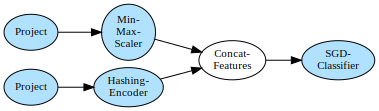

In [2]:
from lale.lib.rasl import Project, MinMaxScaler, HashingEncoder, ConcatFeatures
from lale.lib.sklearn import SGDClassifier

trainable = (
    (Project(columns={"type": "number"}) >> MinMaxScaler())
    & (Project(drop_columns={"type": "number"}) >> HashingEncoder())
) >> ConcatFeatures >> SGDClassifier()

trainable.visualize()

For demonstration purposes, we are going to animate the training
progress live one batch at a time.
The following code defines a callback that does this animation.
It gets called each time the final estimator is trained on one
additional batch, and its `score` argument is the accuracy of the
pipeline on that batch.
The callback includes a `sleep` to slow down the process, making
it easier to watch.

In [3]:
import time
import IPython.display
import matplotlib.pyplot as plt

class DemoProgressCallback:
    def __init__(self):
        self.scores = []

    def __call__(self, score, n_batches_scanned, end_of_scanned_batches):
        self.scores.append(score)
        scores_s = ", ".join(f"{s:.1%}" for s in self.scores)
        fig, ax = plt.subplots()
        ax.set_ylim([0, 1])
        ax.plot(range(n_batches_scanned), self.scores)
        IPython.display.clear_output()
        print(f"scanned {n_batches_scanned}, scores {scores_s}")
        plt.show()
        time.sleep(0.2)
        assert len(self.scores) == n_batches_scanned + (1 if end_of_scanned_batches else 0)

Now we are ready to start training.
One of the arguments below worth calling out is
`partial_transform=True`, which allows a partially-trained upstream
operator to transform data for training downstream operators even
before the upstream operator has been fully trained.
This behavior deviates from the standard scikit-learn semantics and is
only justifiable under the assumption that the upstream operator is
convergent.

scanned 11, scores 35.4%, 66.7%, 60.6%, 77.8%, 72.7%, 47.5%, 64.6%, 78.8%, 48.5%, 68.7%, 90.0%


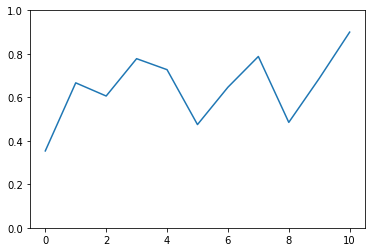

In [4]:
from lale.lib.rasl import fit_with_batches, get_scorer, PrioBatch

accuracy_scorer = get_scorer("accuracy")
trained = fit_with_batches(
    pipeline=trainable,
    batches=openml_data_loader("credit-g", 99),
    scoring=accuracy_scorer,
    unique_class_labels=["bad", "good"],
    max_resident=None,
    prio=PrioBatch(),
    partial_transform=True,
    verbose=0,
    progress_callback=DemoProgressCallback(),
)

Besides supporting training on a batch generator, Lale also supports
scoring on a batch generator.
That means that during scoring, there is never more than one batch of
the data resident at the same time.

In [5]:
overall_score = accuracy_scorer.score_estimator_batched(
    trained, openml_data_loader("credit-g", 99)
)
print(f"overall score {overall_score:.1%}")

overall score 70.2%


Internally, Lale implements operators, metrics, and pipeline that
support batching by expressing them in relational algebra.
Hence, the package name in the above imports is `lale.lib.rasl`,
where RASL stands for Relational Algebra for Scikit-Learn.
The following paper has more information on the algebraic
underpinnings for batching (but not on batching itself):
    
```bibtex
@InProceedings{sahni_et_al_2021,
  title = "{RASL}: Relational Algebra in Scikit-Learn Pipelines",
  author = "Sahni, Chirag and Kate, Kiran and Shinnar, Avraham and Lam, Hoang Thanh and Hirzel, Martin",
  booktitle = "Workshop on Databases and AI (DBAI@NeurIPS)",
  year = 2021,
  month = dec,
  url = "https://openreview.net/forum?id=u9ct1gjoDcn" }
```

## 11.2 Grammars for Recursive Search Spaces

Most AutoML tools support searching over two aspects of a
machine-learning pipeline, namely operator selection and
hyperparameter tuning.
However, some AutoML tools also support searching over a third aspect
of a pipeline, which is the topology, i.e., the way in which operators
are connected by edges.
Such tools tend to epxlicitly or implicitly involve a recursive
grammar over different possible pipeline choices.
Lale supports experimental support for pipeline grammars, as shown
below.

In [6]:
from lale.grammar import Grammar
from lale.lib.sklearn import StandardScaler
from lale.lib.sklearn import PCA
from lale.lib.sklearn import SelectKBest
from lale.lib.sklearn import PolynomialFeatures
from lale.lib.sklearn import DecisionTreeClassifier
from lale.lib.sklearn import LogisticRegression
from lale.lib.sklearn import GaussianNB
from lale.lib.lale import ConcatFeatures
from lale.lib.lale import NoOp

g = Grammar()

g.start = g.tree >> g.estimator
g.tree = g.node | g.tree >> g.node | (g.tree & g.tree) >> ConcatFeatures
g.node = g.transformer | g.estimator
g.transformer = StandardScaler | PCA | SelectKBest | PolynomialFeatures
g.estimator = DecisionTreeClassifier | LogisticRegression | GaussianNB

The above grammar is recursive, because `g.tree` is used both on the
left-hand side and on the right-hand side of the same production.
That means that this grammar can generate pipelines with (possibly
deeply) nested trees.
Let's sample a few such pipelines and visualize them to illustrate
what the grammar does.

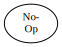

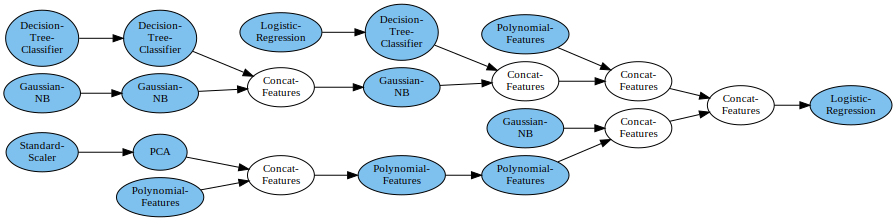

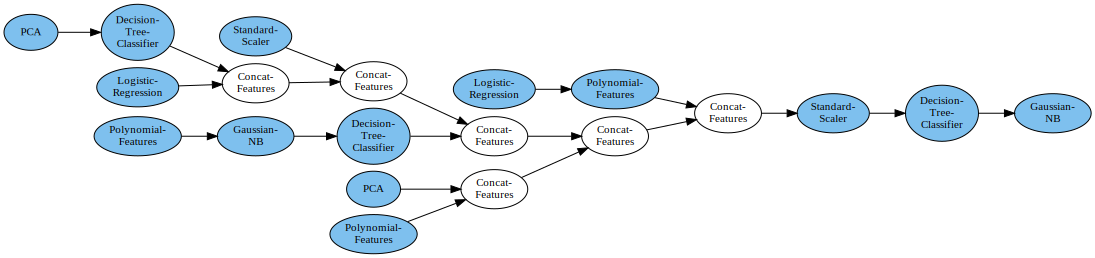

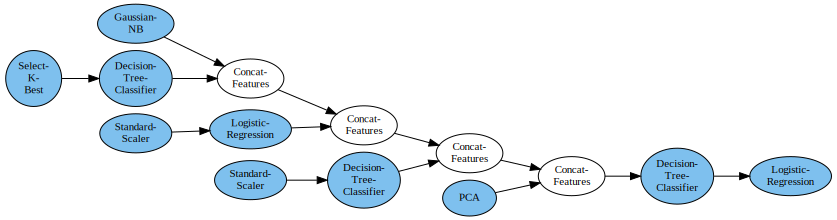

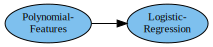

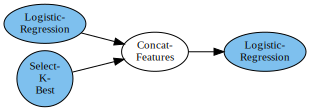

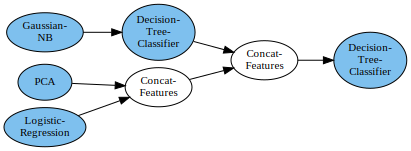

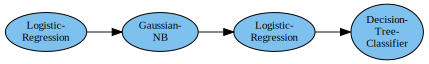

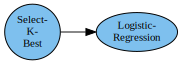

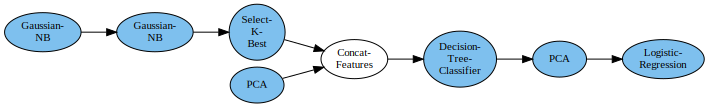

In [7]:
pool = {g.sample(15) for _ in range(10)}
for tree in pool:
    tree.visualize()

Several of these pipelines are unusual, which may be good or bad for
predictive performance.
To see how well they do, we need a dataset; we will preprocess it such
that it has only numeric features.

In [8]:
import lale.datasets.openml

(train_X, train_y), (test_X, test_y) = lale.datasets.openml.fetch(
    "credit-g", "classification", preprocess=True
)

Now, we can simply create a choice over all the above pipelines and
run a Hyperopt search on that choice.

In [9]:
import lale.operators
from lale.lib.lale import Hyperopt

planned = lale.operators.make_choice(*pool)
trained = planned.auto_configure(
    train_X, train_y, optimizer=Hyperopt, max_evals=20
)

100%|██████████| 20/20 [01:26<00:00,  4.32s/trial, best loss: 0.259672263589135]
3 out of 20 trials failed, call summary() for details.
Run with verbose=True to see per-trial exceptions.


As usual, the resulting `trained` pipeline is the one that performed
best (as evaluated by cross-validation) out of all the pipelines tried
during the search.

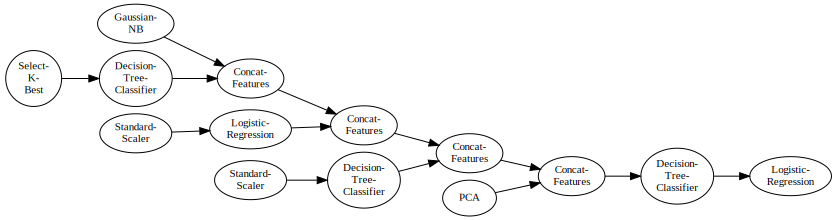

In [10]:
trained.visualize()

The following code evaluates the accuracy of the `trained` pipeline on
the hold-out set.

In [11]:
from sklearn.metrics import accuracy_score
print(f"accuracy {accuracy_score(test_y, trained.predict(test_X)):.1%}")

accuracy 74.5%


This paper has more details on pipeline grammars in Lale:

```bibtex
@InProceedings{baudart_et_al_2020,
  title = "Lale: Consistent Automated Machine Learning",
  author = "Baudart, Guillaume and Hirzel, Martin and Kate, Kiran and Ram, Parikshit and Shinnar, Avraham",
  booktitle = "KDD Workshop on Automation in Machine Learning (AutoML@KDD)",
  year = 2020,
  month = aug,
  url = "https://arxiv.org/abs/2007.01977" }
```

## 11.3 Conclusion

This concludes the Lale tutorial.
Thank you for your attention!
We hope you enjoyed it and learned something useful.
We encourage you to star and contribute to our open-source repository.
Also, feel free to reach out if you have additional questions,
feedback, or would like to collaborate.